In [1]:
import os
import PIL
import PIL.Image
import pathlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


import imgaug as ia
from imgaug import augmenters as iaa


import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [2]:
 def downscale_images(images, scale=30):
    """
    Downscales images in an array.
    Args:
        images: array of images to be downscaled 
        scale: 

    Returns: array of downscaled down images

    """
    resized = []
    
    for img in images:
        
        width = int(img.shape[1] * scale / 100)
        height = int(img.shape[0] * scale / 100)
        dim = (width, height)

        resized.append(cv2.resize(img, dim, interpolation = cv2.INTER_AREA))
    
    return resized


In [3]:
def bgr_to_rgb(images):
    return [cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in images ]

In [ ]:
def load_paintings(path):
    
    # directory with the images
    data_dir = pathlib.Path(path)
    
    
    # how many images are in the directory
    image_count = len(list(data_dir.glob('*')))
    print(f"Number of images found in {path}: {image_count}")


    paintings_path = list(data_dir.glob('*'))
    paintings_path = [str(path) for path in paintings_path]
    
    paintings_filenames = [path.split('/')[1] for path in paintings_path]
    print(paintings_filenames)
    
    # loading images, in BGR
    paintings = [cv2.imread(painting_path) for painting_path in paintings_path]
    paintings = bgr_to_rgb(paintings)
    
    
    # TODO TOHLE TU NECHCI
    paintings = downscale_images(paintings)
    
    return paintings_filenames, paintings


In [ ]:
stolen_art_dir_path = "./Tate-500-wop-opac/"
paintings_filenames, paintings = load_paintings(stolen_art_dir_path)

# Data Augmentation

## Imgaug

In [6]:
def compare_orig_aug(orig, aug, limit = 15):
    
    for i in range(0, len(orig)): 
        ia.imshow(np.hstack([orig[i], aug[i]]))
        if i >= limit:
            break

In [7]:
def get_augmented(images):
    """
    Augments each image in an input array once. 
    
    Args: 
        images: images to be augmented

    Returns: an array of augmented images, size of an output array = size of input array

    """
    
    seq = iaa.Sequential([
        
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    
    iaa.LinearContrast((0.75, 1.5)),
        
    iaa.Sometimes(0.1,
        iaa.Cutout(fill_mode="gaussian", fill_per_channel=True) ), # cutout a square, fill it with noise
    # algo should not rely on just one area of keypoints
        
    iaa.GaussianBlur(sigma=(0, 3.0)), # blur images with a sigma of 0 to 3.0
   
    iaa.Sometimes(0.25,
                iaa.JpegCompression(compression=(0, 30)) ),# degrade the quality of images by JPEG-compressing them.  
    
    #iaa.Sometimes(0.1,    
    #            iaa.imgcorruptlike.MotionBlur(severity=1) ),  
        
    iaa.Affine(
        #scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # zooming
        translate_percent={"x": (-0.05, 0.05), "y": (-0.05, 0.05)}, # shifting on axis
        rotate=(-15, 15), # rotating
        )
        ], random_order = True)
    
    augmented = seq(images=images)
        
    return augmented
    
    

In [8]:
augmented = get_augmented(paintings)

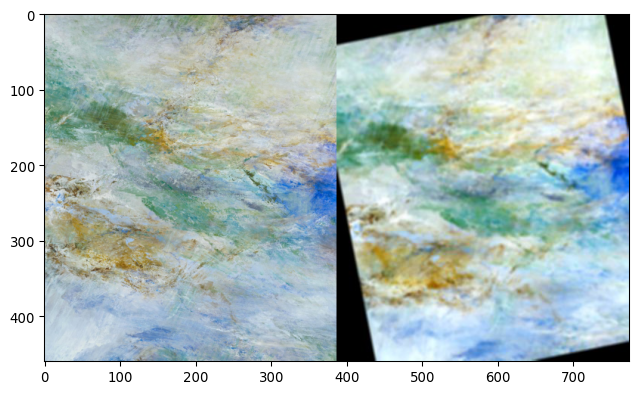

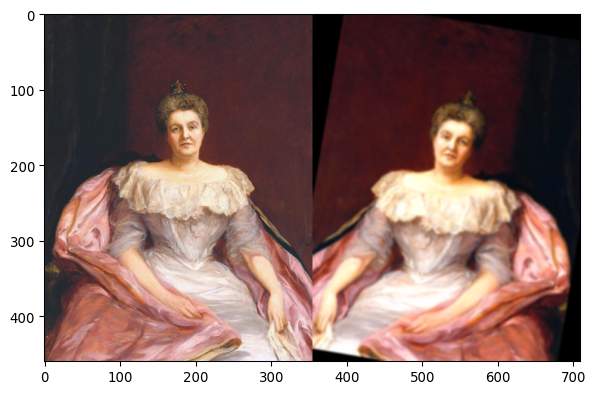

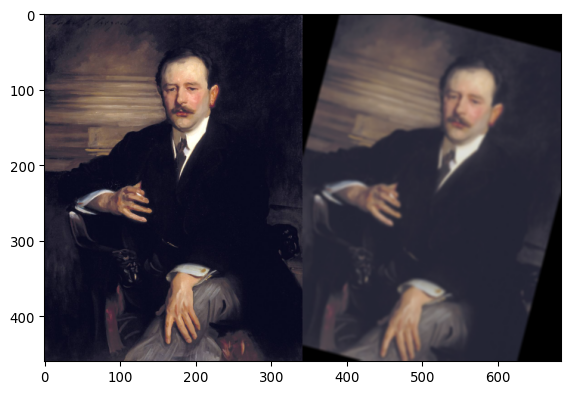

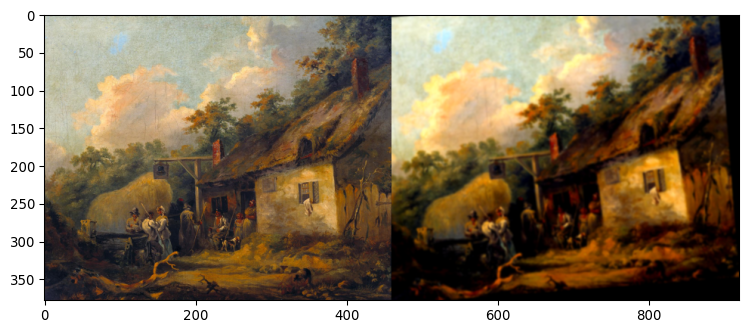

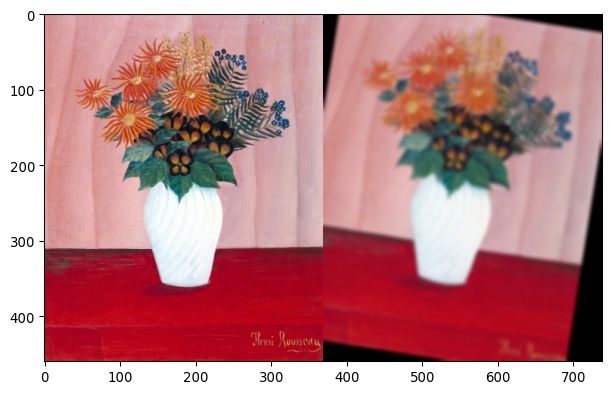

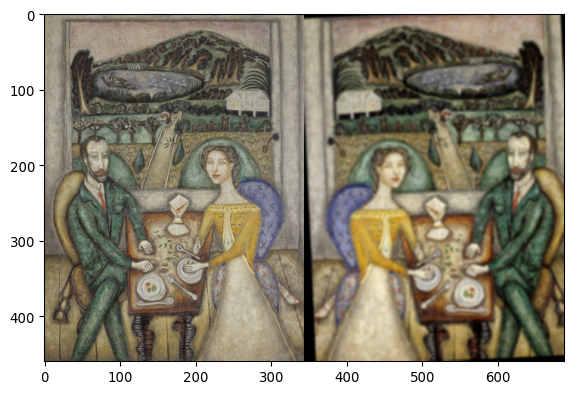

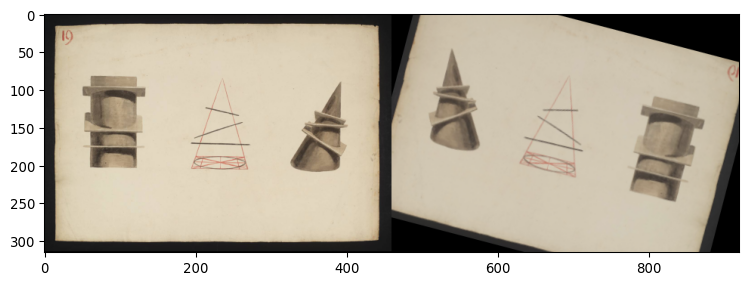

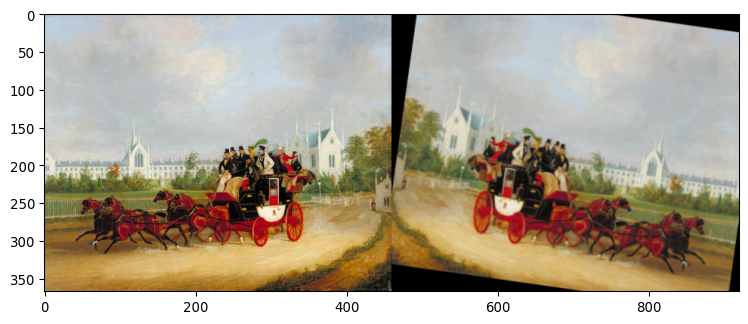

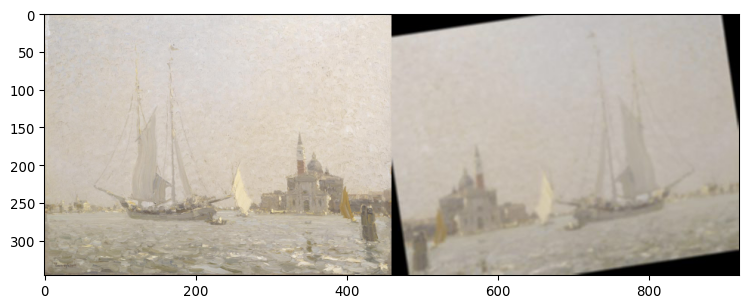

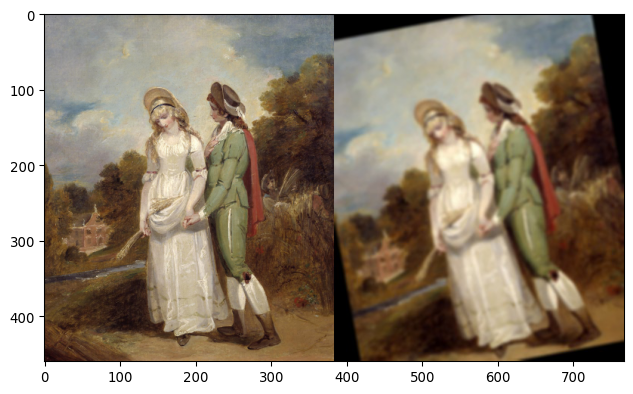

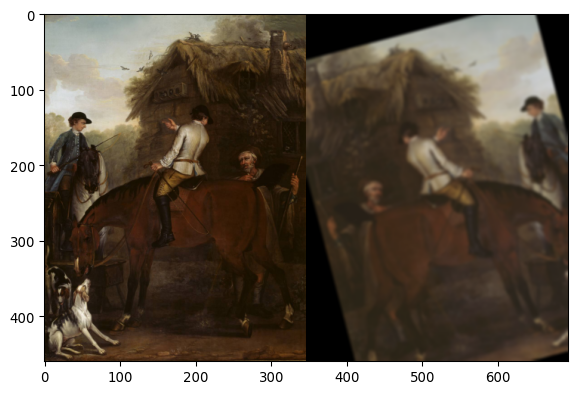

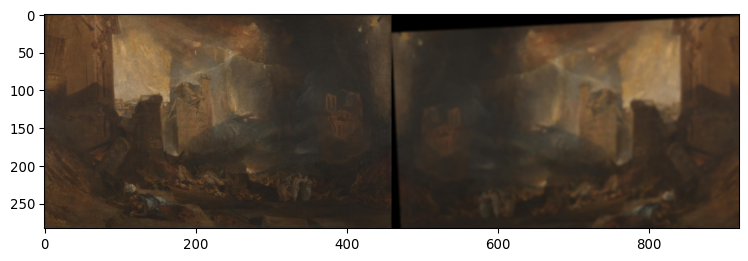

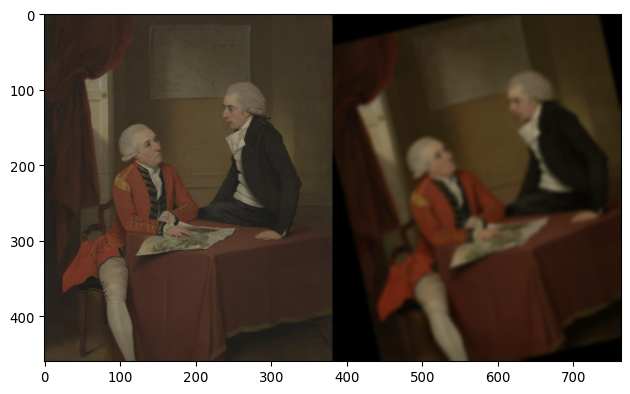

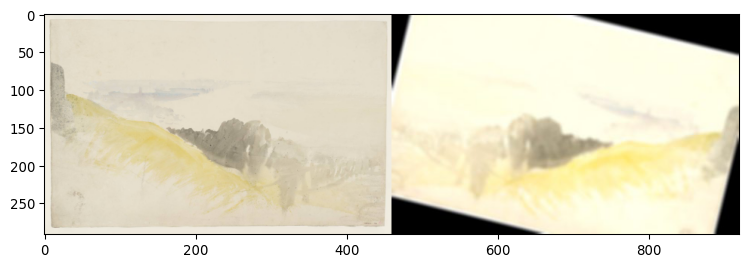

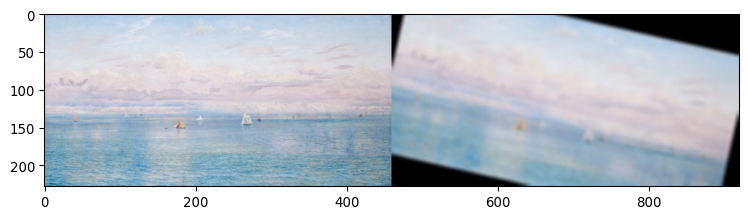

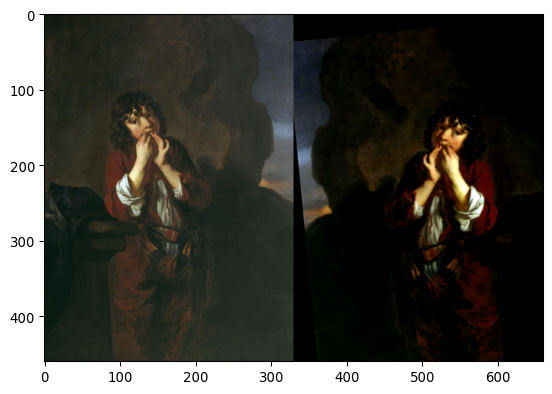

In [10]:
compare_orig_aug(paintings, augmented)

### Nápady + todo
- zvoleným parametrům u augmentace by měl předcházet nějaký výzkum, např. když budu vědět, že 10 % obrazů co uživatel vyfotí mají nějaký motion blur, použiji iaa.Sometimes(0.1, motion...), aby pak augmentovaný dataset lépe reprezentoval reálná data a já pak měl přesnější accuracy
- jak správně nasimulovat různé světelné podmínky?